In [78]:
%matplotlib inline
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

from torch.utils.data import DataLoader
from p2ch13.dsets import getCandidateInfoList, getCt, TrainingLuna2dSegmentationDataset, CandidateInfoTuple
from p2ch13.model import UNetWrapper
from p2ch13.model import SegmentationMask, MaskTuple
from p2ch13.vis import build2dLungMask
from util.util import xyz2irc

In [79]:
candidateInfo_list = getCandidateInfoList(requireOnDisk_bool=False)
candidateInfo_list[0]
series_list = sorted(set(t.series_uid for t in candidateInfo_list))

In [ ]:
def show_positive_slices_grid(uid, max_samples=9):
    dataset = TrainingLuna2dSegmentationDataset(series_uid=uid)
    ct = getCt(uid)

    candidate_list = getCandidateInfoList()

    cand_per_slice = {}
    for cand in candidate_list:
        if cand.series_uid == uid and cand.isNodule_bool:
            center_irc = xyz2irc(cand.center_xyz, ct.origin_xyz, ct.vxSize_xyz, np.eye(3)) 
            slice_idx = int(round(center_irc[0]))
            if slice_idx not in cand_per_slice:
                cand_per_slice[slice_idx] = []
            cand_per_slice[slice_idx].append(cand.diameter_mm)

    positive_samples = []
    for i in range(len(dataset)):
        ct_t, mask_t, series_uid, slice_index = dataset[i]
        if mask_t.sum() > 0:
            diameters = cand_per_slice.get(slice_index, [])
            positive_samples.append((ct_t[0].numpy(), mask_t[0].numpy(), diameters, slice_index))
            if len(positive_samples) >= max_samples:
                break

    num_samples = len(positive_samples)
    cols = 3
    rows = (num_samples + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(12, 4 * rows))

    for i, (ct_slice, mask_slice, diameters, slice_index) in enumerate(positive_samples):
        r, c = divmod(i, cols)
        ax = axs[r][c] if rows > 1 else axs[c]
        ax.imshow(ct_slice, cmap='gray', vmin=-1000, vmax=300)
        ax.imshow(mask_slice, cmap='Reds', alpha=0.3)
        
        if diameters:
            diam_str = ', '.join([f'{d:.1f}' for d in diameters])
            title = f'Slice {slice_index} (Nodule)\nDiam: {diam_str} mm'
        else:
            title = f'Slice {slice_index} (Nodule)'
        ax.set_title(title)
        ax.axis('off')

    for j in range(num_samples, rows * cols):
        r, c = divmod(j, cols)
        ax = axs[r][c] if rows > 1 else axs[c]
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle(f'Positive Nodule Slices - UID: {uid}', y=1.02)
    plt.show()

2025-07-18 10:46:19,551 INFO     pid:24356 p2ch13.dsets:271:__init__ <p2ch13.dsets.TrainingLuna2dSegmentationDataset object at 0x000002285B323B50>: 1 general series, 29 slices, 9 nodules


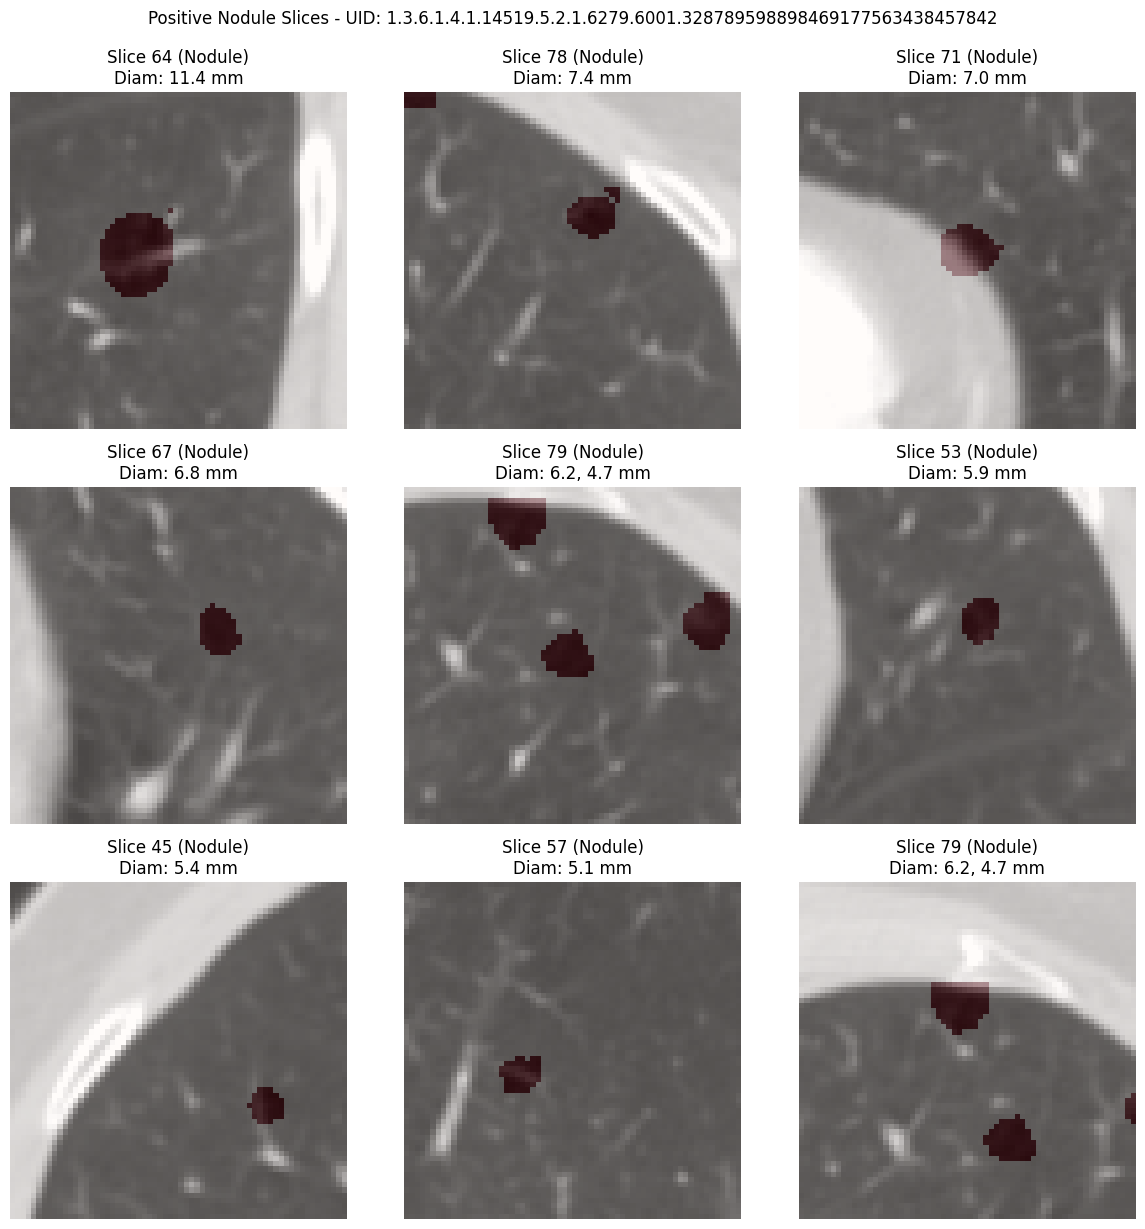

In [81]:
show_positive_slices_grid("1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842")

In [ ]:
def show_all_nodules(series_uid, candidateInfo_list):
    ct = getCt(series_uid)
    
    positive_samples = [
        cand for cand in candidateInfo_list
        if cand.series_uid == series_uid and cand.isNodule_bool
    ]
    
    fig, axs = plt.subplots(3, 3, figsize=(15, 15)) 
    axs = axs.flatten()

    for i, cand in enumerate(positive_samples):
        center_irc = xyz2irc(cand.center_xyz, ct.origin_xyz, ct.vxSize_xyz, ct.direction_a)
        slice_idx = int(round(center_irc[0]))
        center_r = int(round(center_irc[1]))
        center_c = int(round(center_irc[2]))
        radius = int(round(cand.diameter_mm / ct.vxSize_xyz[1]) / 2)

        ct_slice = ct.hu_a[slice_idx]
        axs[i].imshow(ct_slice, cmap='gray', vmin=-1000, vmax=300)
        
        rect = patches.Rectangle(
            (center_c - radius, center_r - radius),
            2 * radius, 2 * radius,
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        axs[i].add_patch(rect)
        axs[i].set_title(f"diameter = {cand.diameter_mm:.1f} mm")
        axs[i].axis('off')
    
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

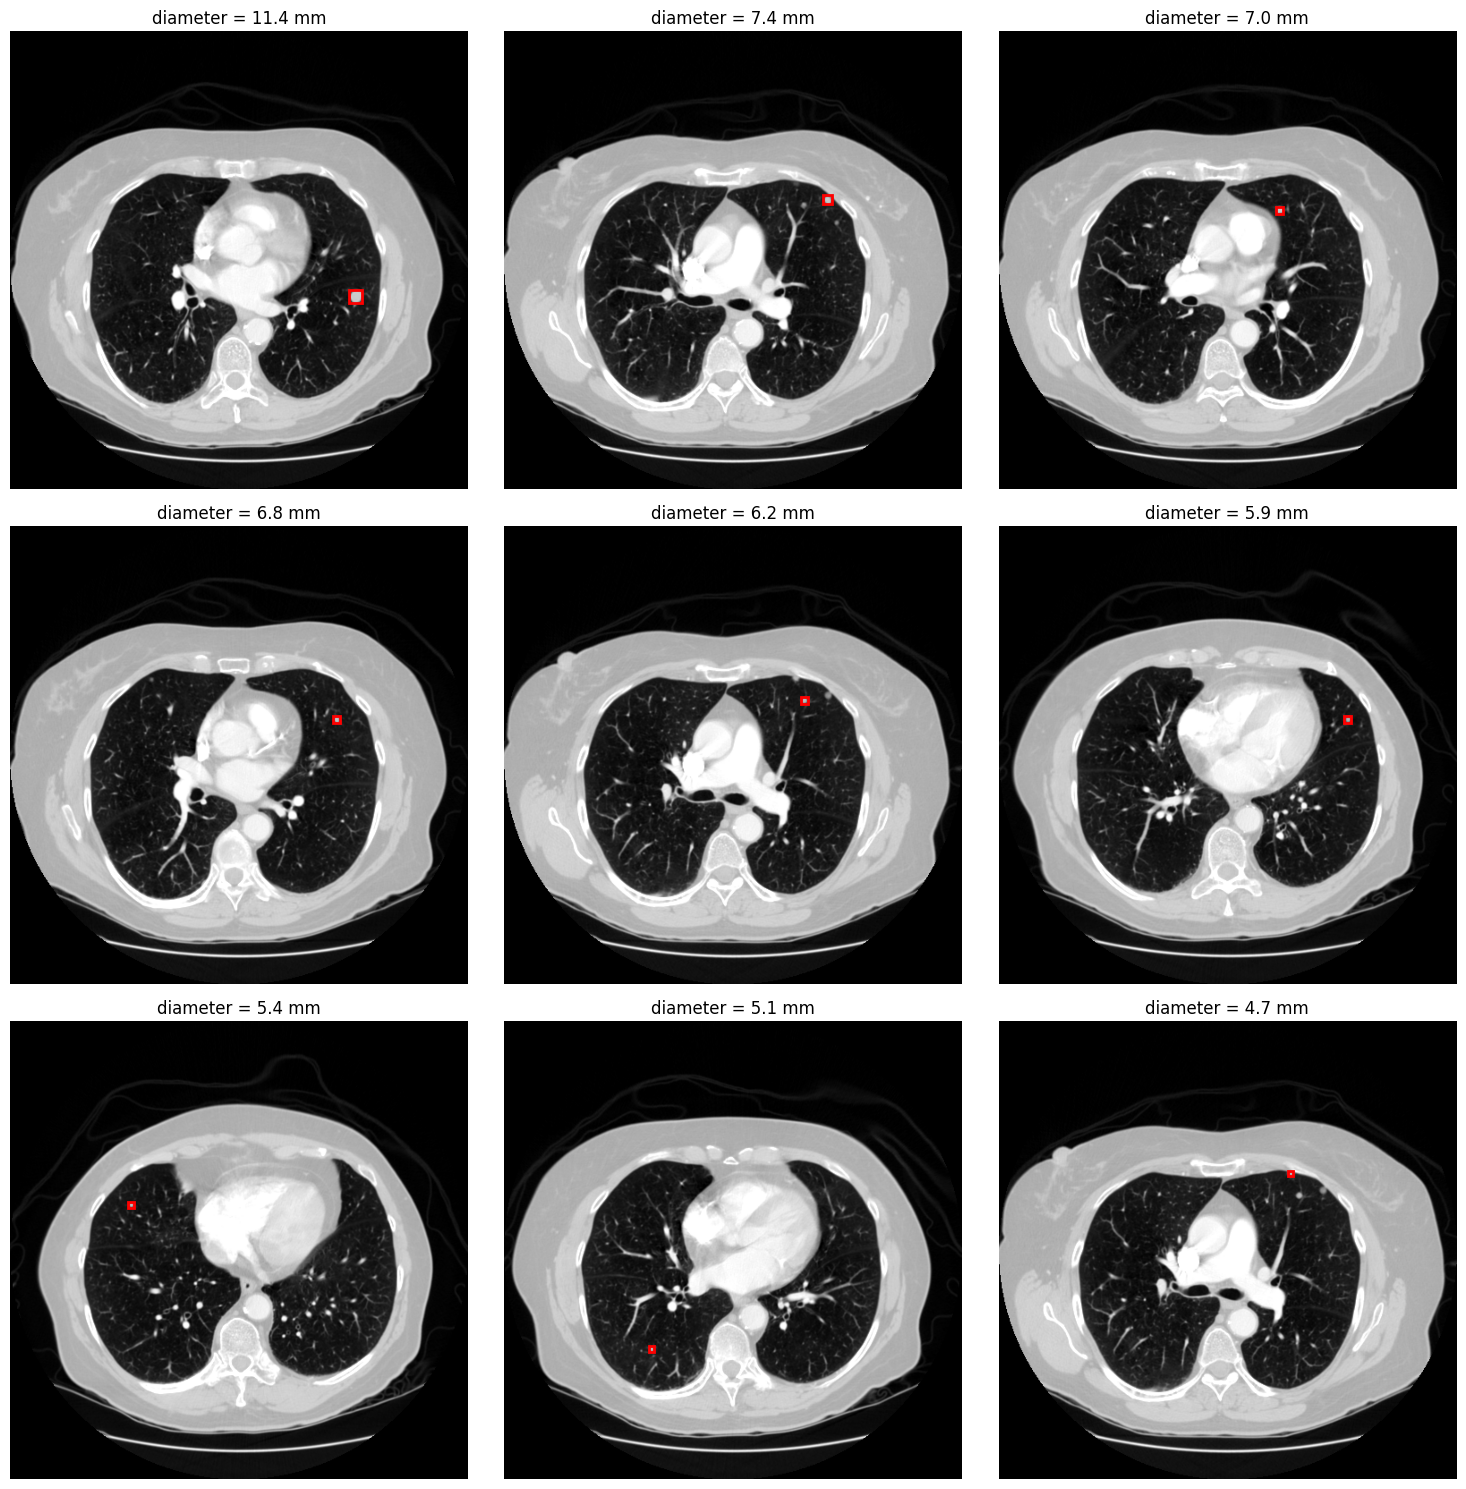

In [ ]:
ashow_all_nodules("1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842", candidateInfo_list)

2025-07-18 10:51:39,598 INFO     pid:24356 p2ch13.dsets:271:__init__ <p2ch13.dsets.TrainingLuna2dSegmentationDataset object at 0x000002285A74F4C0>: 1 general series, 29 slices, 9 nodules


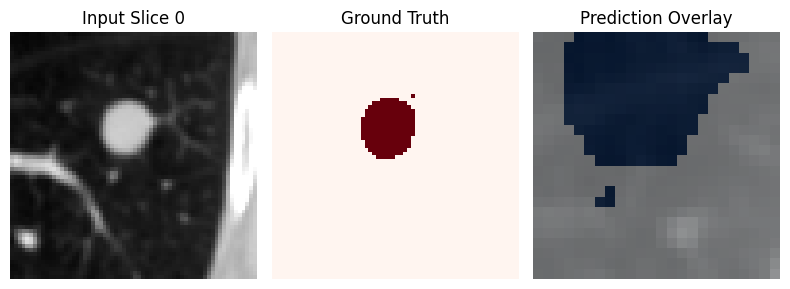

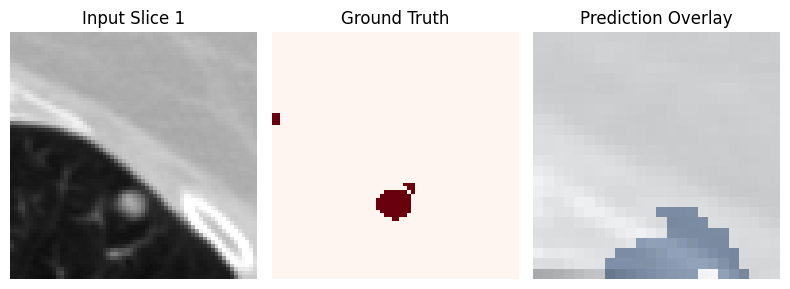

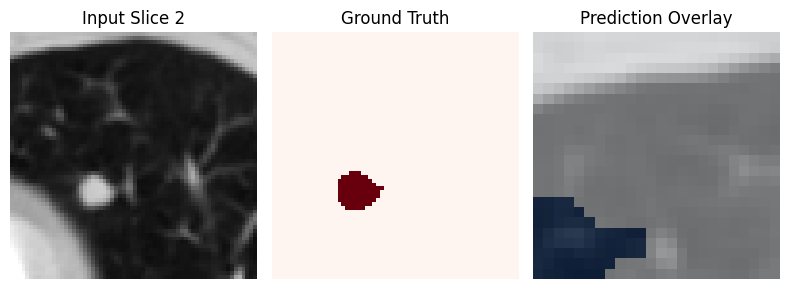

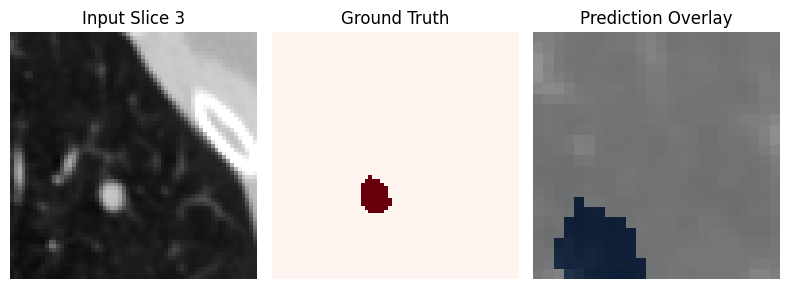

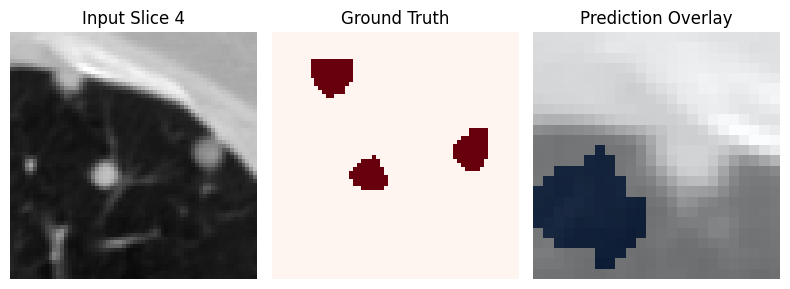

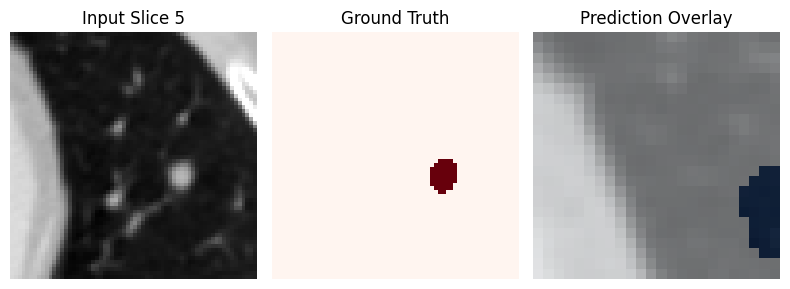

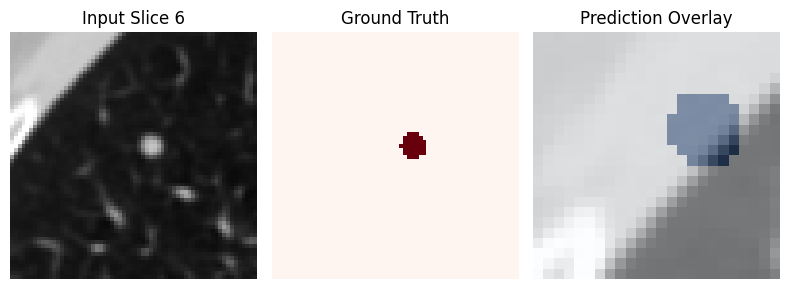

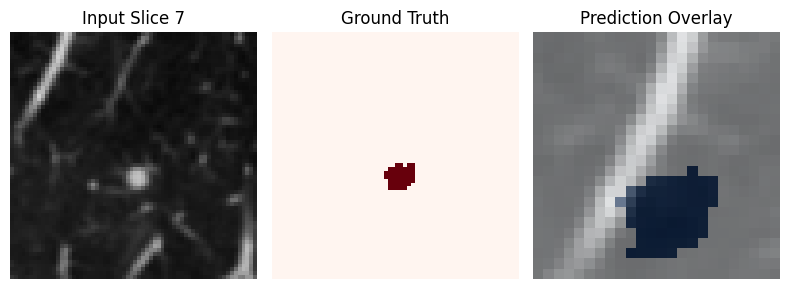

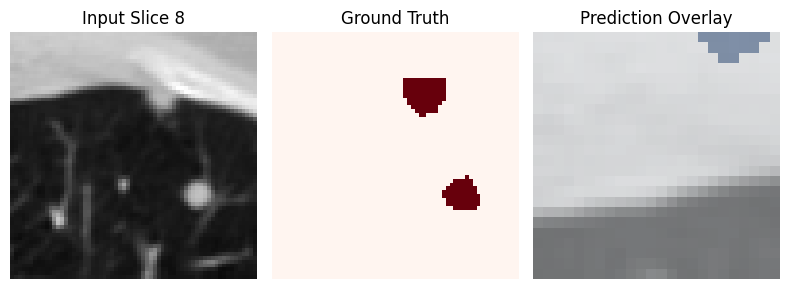

In [ ]:
model_path = "data-unversioned/part2/models/p2ch13/seg_2025-07-18_09.54.37_my-final-run.3000000.state"
uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNetWrapper(
    in_channels=7,
    n_classes=1,
    wf=4,
    depth=3,
    batch_norm=True
)

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint["model_state"], strict=False)
model = model.to(device)
model.eval()


dataset = TrainingLuna2dSegmentationDataset(series_uid=uid)
loader = DataLoader(dataset, batch_size=1)


with torch.no_grad():
    for i, (ct_t, mask_t, series_uid, center_slice_idx) in enumerate(loader):
        ct_t = ct_t.to(device)  # [1, 7, H, W]
        pred_mask = model(ct_t)  # [1, 1, H, W]

        ct_slice = ct_t[0, 3].cpu().numpy()       
        true_mask = mask_t[0, 0].cpu().numpy()
        pred_mask_np = pred_mask[0, 0].cpu().numpy()

        fig, axs = plt.subplots(1, 3, figsize=(8, 3)) 

        axs[0].imshow(ct_slice, cmap='gray', vmin=-1000, vmax=300, interpolation='nearest')
        axs[0].set_title(f"Input Slice {i}")
        axs[0].axis('off')

        axs[1].imshow(true_mask, cmap='Reds', interpolation='nearest')
        axs[1].set_title("Ground Truth")
        axs[1].axis('off')

        axs[2].imshow(ct_slice, cmap='gray', vmin=-1000, vmax=300, interpolation='nearest')
        axs[2].imshow(pred_mask_np > 0.5, cmap='Blues', alpha=0.4, interpolation='nearest')
        axs[2].set_title("Prediction Overlay")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

        if i >= 8:
            break

2025-07-18 10:55:20,198 INFO     pid:24356 p2ch13.dsets:271:__init__ <p2ch13.dsets.TrainingLuna2dSegmentationDataset object at 0x0000022860C76440>: 1 general series, 29 slices, 9 nodules


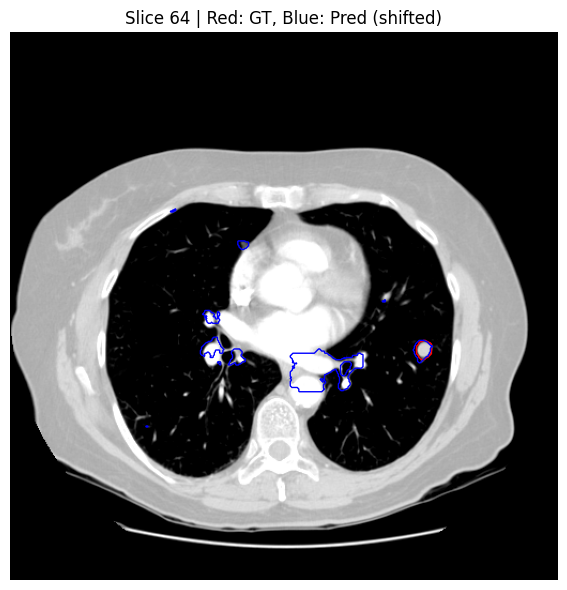

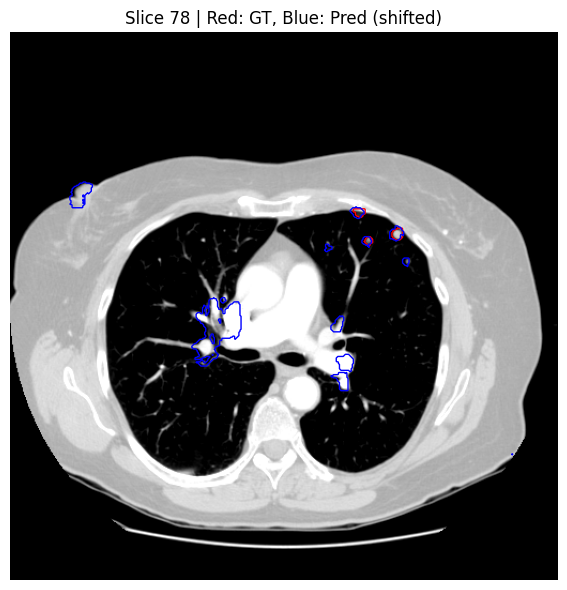

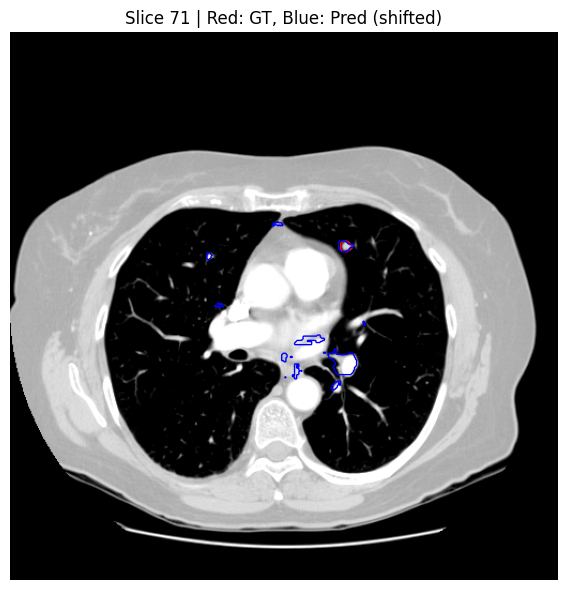

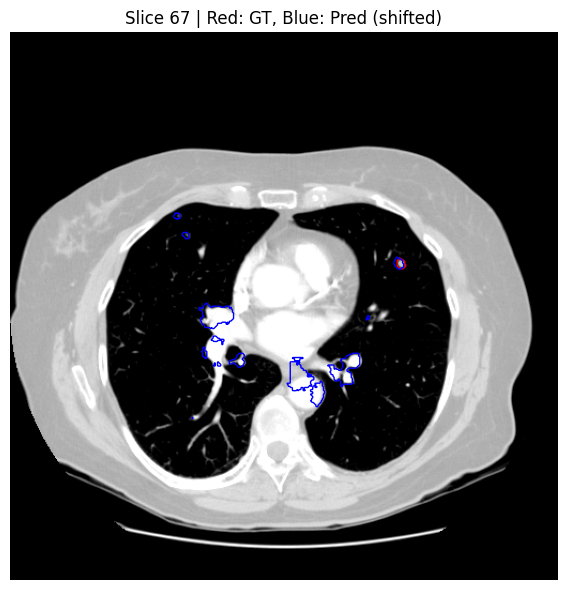

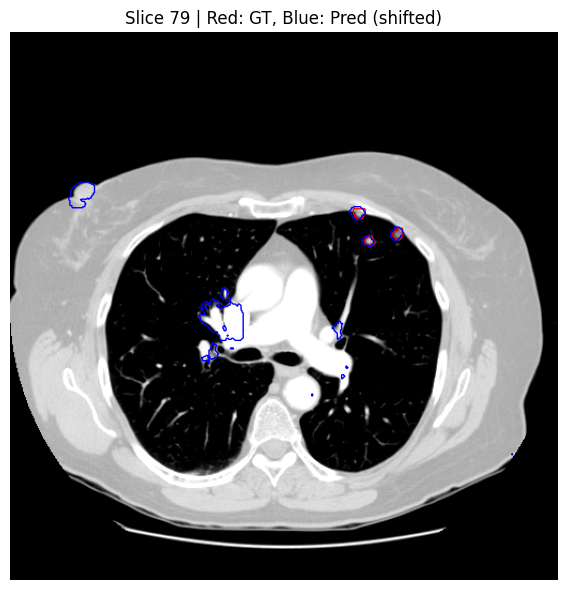

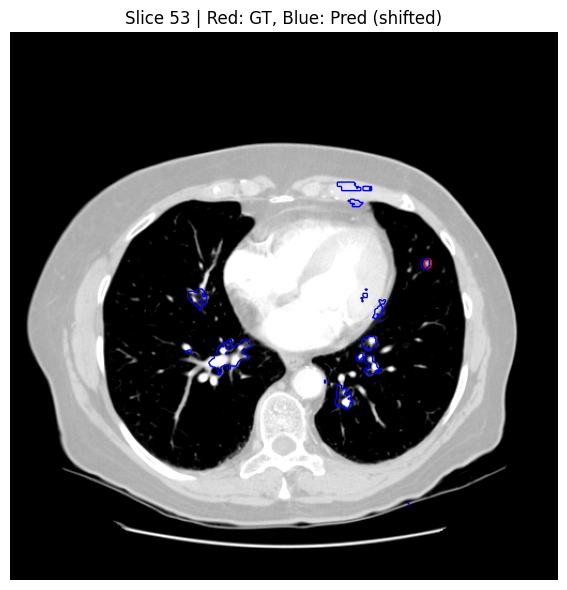

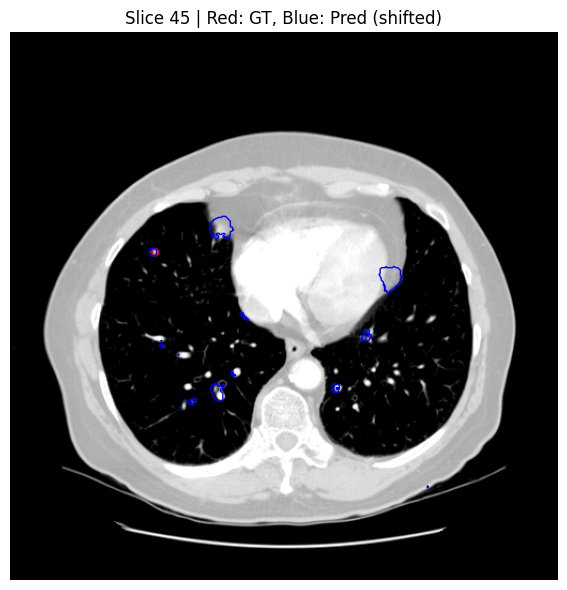

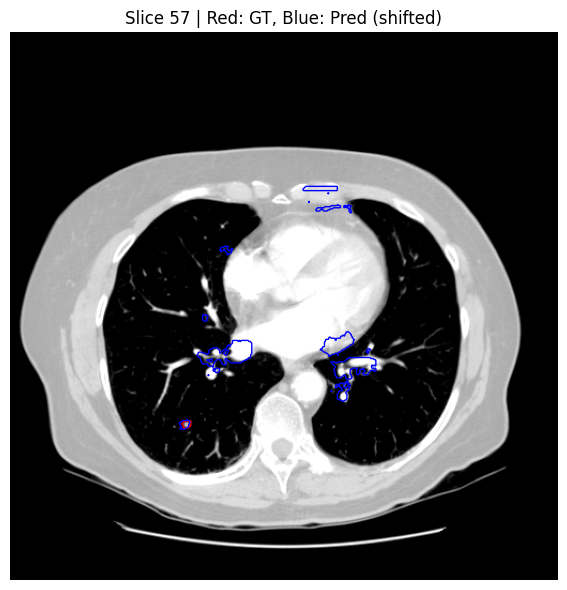

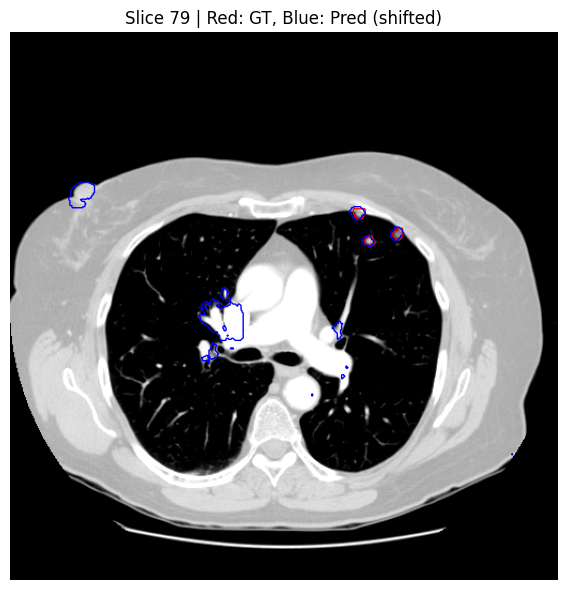

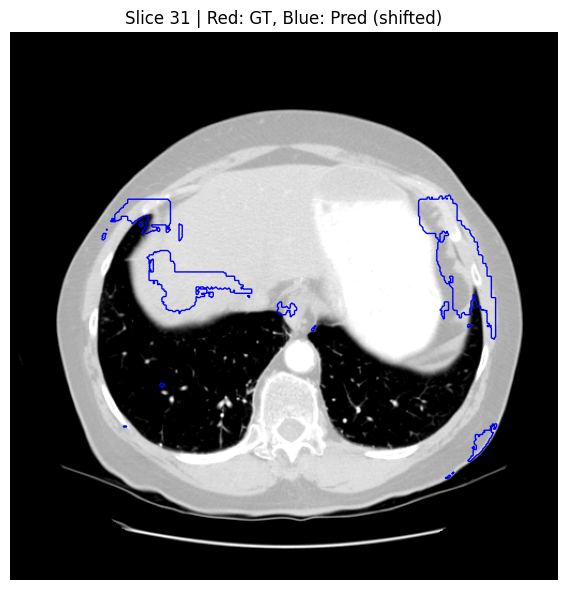

In [ ]:
uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842"
model_path = "data-unversioned/part2/models/p2ch13/seg_2025-07-18_09.54.37_my-final-run.3000000.state"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = UNetWrapper(in_channels=7, n_classes=1, wf=4, depth=3, batch_norm=True)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint["model_state"], strict=False)
model = model.to(device)
model.eval()


dataset = TrainingLuna2dSegmentationDataset(series_uid=uid)
ct = getCt(uid)
center_slice_list = [
    int(round(xyz2irc(c.center_xyz, ct.origin_xyz, ct.vxSize_xyz, ct.direction_a)[0]))
    for c in dataset.candidateInfo_list
]


with torch.no_grad():
    for i, slice_idx in enumerate(center_slice_list):
        ct_t, mask_t, _, _ = dataset.getitem_fullSlice(uid, slice_idx)
        ct_input = ct_t.unsqueeze(0).to(device)
        pred_mask = model(ct_input)

        ct_slice = ct_t[3].cpu().numpy()
        true_mask = mask_t[0].cpu().numpy()
        pred_mask_np = pred_mask[0, 0].cpu().numpy()
        pred_binary = pred_mask_np > 0.5

        pred_shifted = shift(pred_binary.astype(float), shift=(20, 18), order=0) > 0.5

        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(ct_slice, cmap='gray', vmin=-800, vmax=200)

        ax.contour(true_mask, colors='red', linewidths=1)

        ax.contour(pred_shifted, colors='blue', linewidths=1)

        ax.set_title(f"Slice {slice_idx} | Red: GT, Blue: Pred (shifted)", fontsize=12)
        ax.axis('off')
        plt.tight_layout()
        plt.show()

        if i >= 9:
            break

2025-07-18 10:57:28,638 INFO     pid:24356 p2ch13.dsets:271:__init__ <p2ch13.dsets.TrainingLuna2dSegmentationDataset object at 0x0000022864CF4A30>: 1 general series, 29 slices, 9 nodules


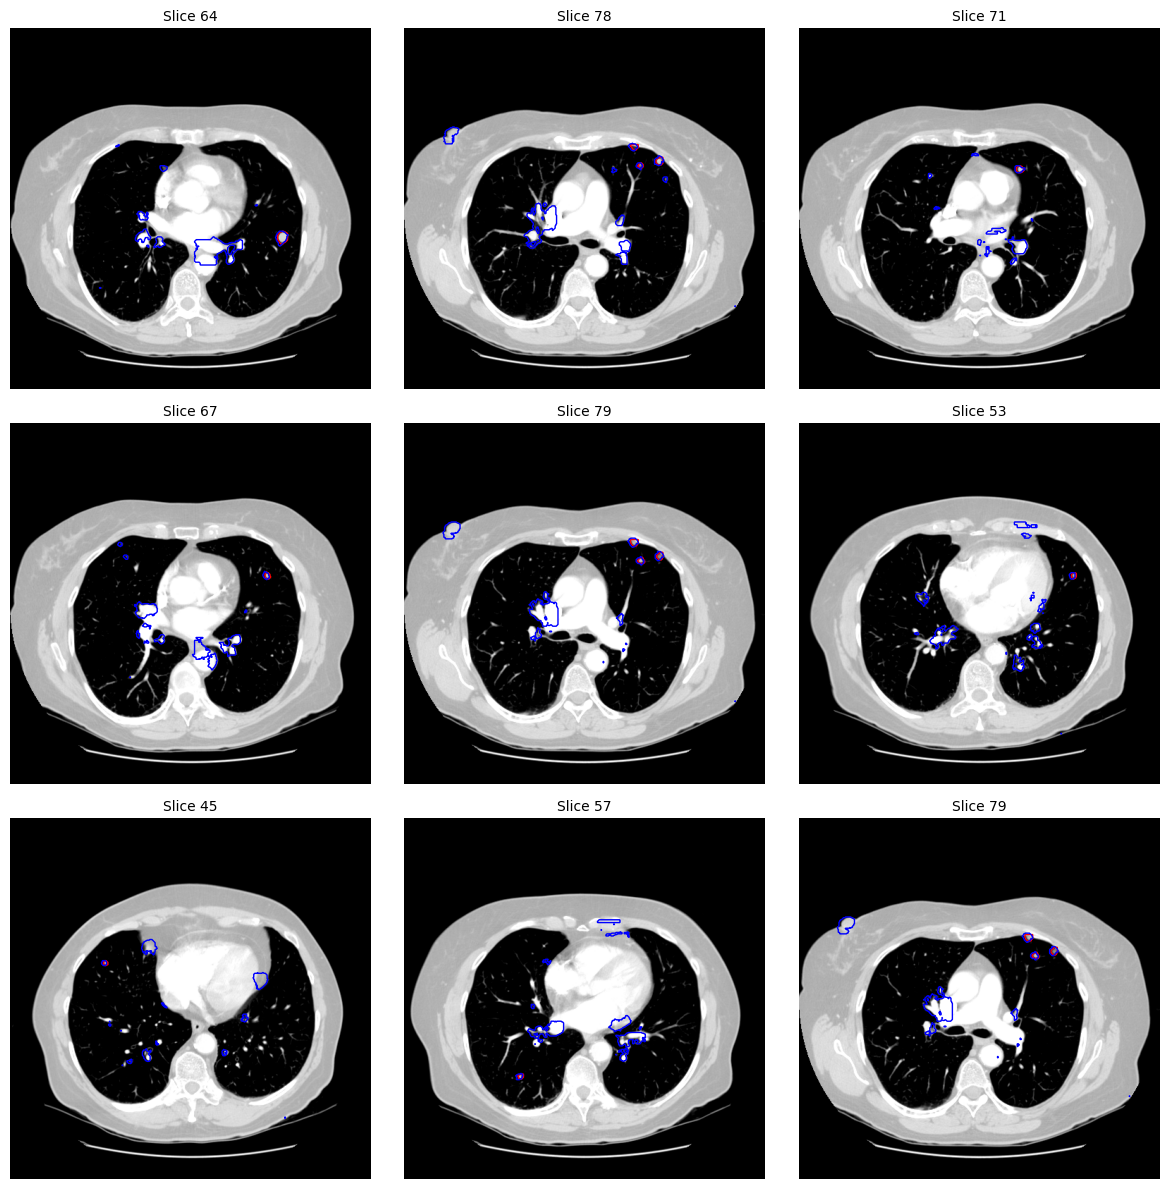

In [ ]:
uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842"
model_path = "data-unversioned/part2/models/p2ch13/seg_2025-07-18_09.54.37_my-final-run.3000000.state"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNetWrapper(in_channels=7, n_classes=1, wf=4, depth=3, batch_norm=True)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint["model_state"], strict=False)
model = model.to(device)
model.eval()

dataset = TrainingLuna2dSegmentationDataset(series_uid=uid)
ct = getCt(uid)
center_slice_list = [
    int(round(xyz2irc(c.center_xyz, ct.origin_xyz, ct.vxSize_xyz, ct.direction_a)[0]))
    for c in dataset.candidateInfo_list
]

fig, axs = plt.subplots(3, 3, figsize=(12, 12))

with torch.no_grad():
    for i, slice_idx in enumerate(center_slice_list[:9]):
        ct_t, mask_t, _, _ = dataset.getitem_fullSlice(uid, slice_idx)
        ct_input = ct_t.unsqueeze(0).to(device)
        pred_mask = model(ct_input)

        ct_slice = ct_t[3].cpu().numpy()
        true_mask = mask_t[0].cpu().numpy()
        pred_mask_np = pred_mask[0, 0].cpu().numpy()
        pred_binary = pred_mask_np > 0.5

        pred_shifted = shift(pred_binary.astype(float), shift=(20, 18), order=0) > 0.5

        ax = axs[i // 3, i % 3]
        ax.imshow(ct_slice, cmap='gray', vmin=-800, vmax=200)

        ax.contour(true_mask, colors='red', linewidths=1)  
        ax.contour(pred_shifted, colors='blue', linewidths=1)     

        ax.set_title(f"Slice {slice_idx}", fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()